In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## **Esplorazione dei Dati (EDA) e Preprocessing**
Per iniziare, esamineremo il dataset per comprendere meglio la distribuzione delle feature e della variabile target. Questa analisi preliminare ci permetterà di individuare eventuali sbilanciamenti, pattern nascosti e fattori critici che possono influenzare le prestazioni del modello predittivo.
</br>
</br>
In particolare, ci concentreremo su:
- La distribuzione della variabile "Response", per verificare eventuali squilibri tra i clienti che accettano o rifiutano l'offerta di cross-selling.
- Le relazioni tra variabili chiave, come Annual Premium, Vehicle Age, Previously Insured, e la risposta del cliente, per identificare eventuali correlazioni significative.


In [ ]:
df = pd.read_csv('/content/drive/My Drive/insurance_cross_sell.csv')

df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Verifichiamo la distribuzione delle variabili numeriche continue per identificare eventuali pattern, outlier e asimmetrie nei dati.

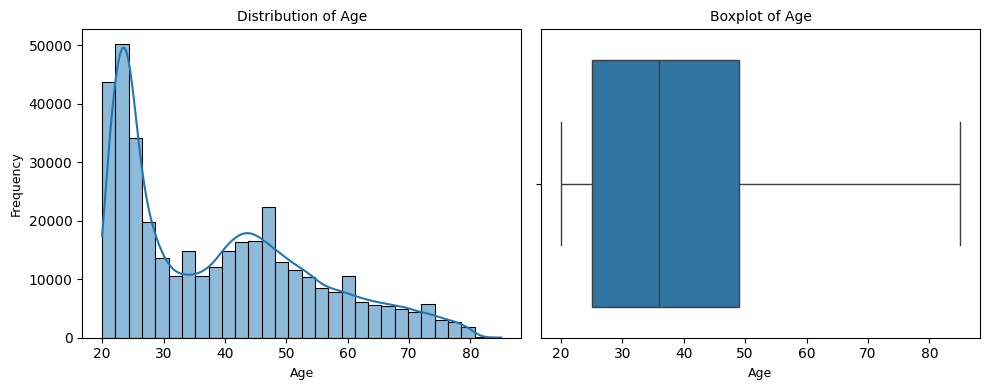

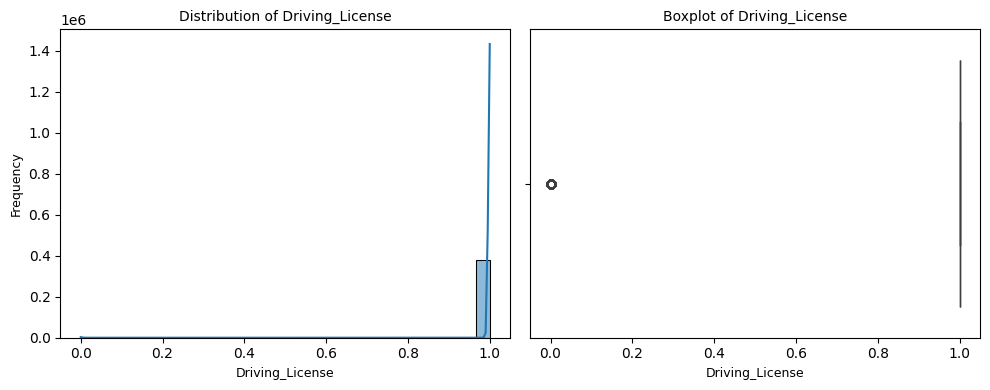

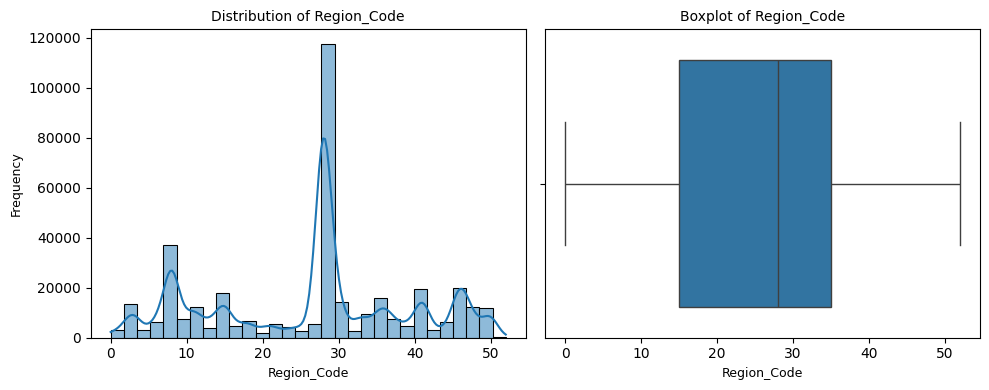

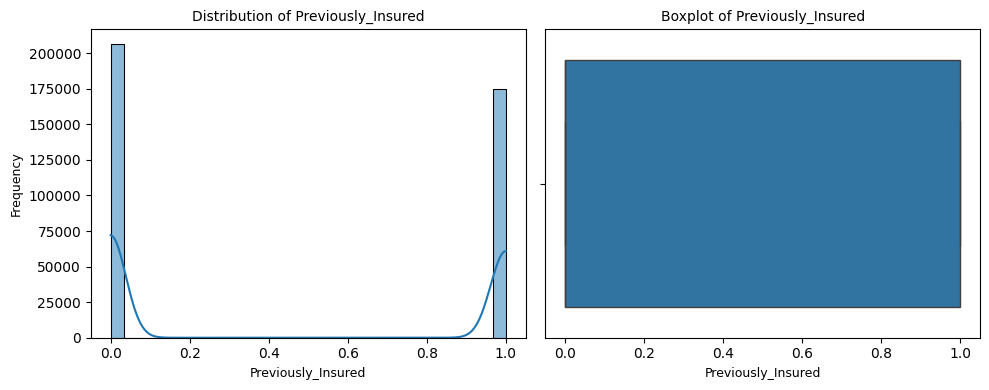

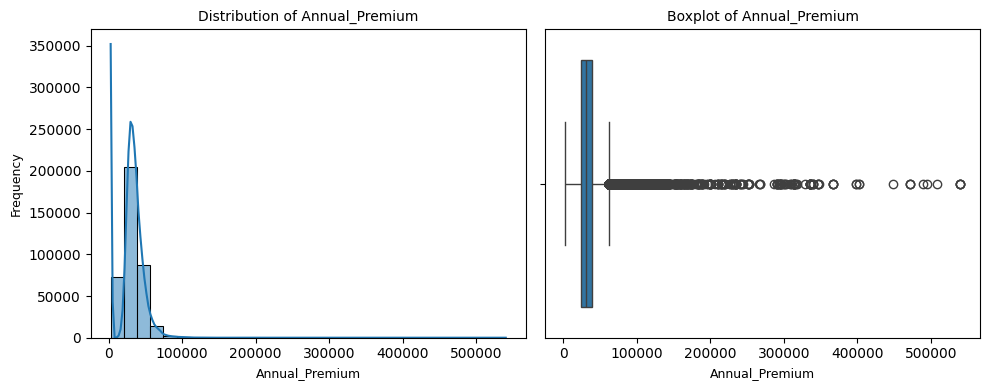

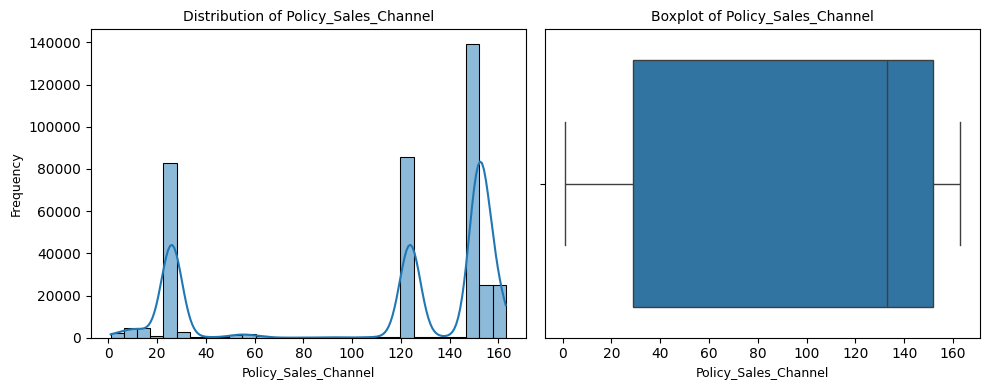

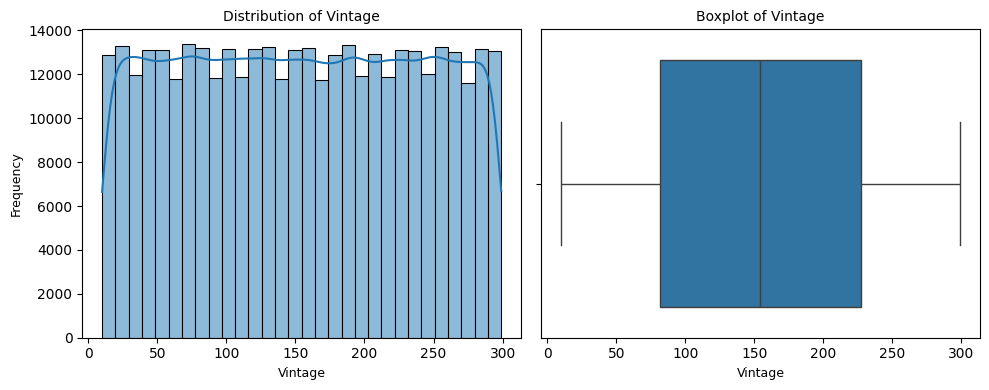

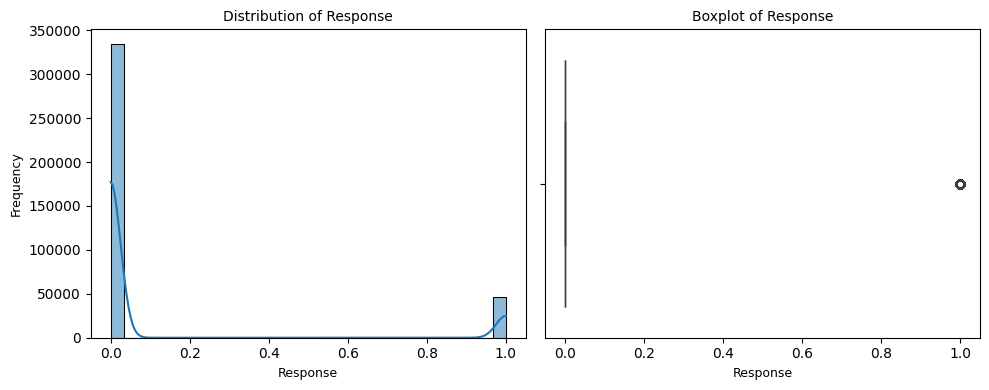

In [ ]:
df.drop(columns=['id'], inplace=True)
def plot_distributions(data):
    # Select numerical columns (integer and float types) from the DataFrame
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

    # Loop through each numerical column to generate distribution plots
    for column in numerical_columns:
        # Create a figure with two subplots: one for the histogram and one for the boxplot
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Histogram to visualize the distribution of the variable
        sns.histplot(df[column], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f"Distribution of {column}", fontsize=10)
        axes[0].set_xlabel(column, fontsize=9)
        axes[0].set_ylabel("Frequency", fontsize=9)

        # Boxplot to detect potential outliers
        sns.boxplot(x=df[column], ax=axes[1])
        axes[1].set_title(f"Boxplot of {column}", fontsize=10)
        axes[1].set_xlabel(column, fontsize=9)

        plt.tight_layout()
        plt.show()


plot_distributions(df)



#### **Distribuzione e Boxplot della variabile Age**  
- La distribuzione dell’età presenta più picchi distinti, suggerendo la presenza di gruppi di clienti con fasce di età ben definite.  
- La fascia più numerosa è compresa tra i 20 e i 40 anni, mentre il numero di clienti diminuisce progressivamente oltre i 50 anni.  
- Il boxplot conferma che non ci sono outlier significativi e che l’età è ben distribuita.  


#### **Distribuzione e Boxplot della variabile Region_Code**  
- La distribuzione della variabile Region_Code è abbastanza variegata, con un picco pronunciato in corrispondenza di una specifica regione.  
- Questo potrebbe indicare una maggiore concentrazione di clienti in quell’area, probabilmente dovuta a fattori geografici o economici che incentivano la sottoscrizione di un'assicurazione.  

#### **Distribuzione e Boxplot della variabile Previously Insured**  
- La distribuzione mostra una netta separazione tra chi ha già un’assicurazione e chi no.  
- La maggior parte dei clienti non ha un’assicurazione precedente, il che potrebbe indicare un target di mercato nuovo per la compagnia assicurativa.  

#### **Distribuzione e Boxplot della variabile Annual_Premium**  
- La distribuzione del premio assicurativo (Annual_Premium) è fortemente asimmetrica, con una coda lunga a destra.  
- La maggior parte dei clienti paga un premio inferiore ai 100.000, mentre alcuni valori estremamente elevati superano i 500.000.  
- Il boxplot evidenzia numerosi outlier, segnalando una forte variabilità nei premi assicurativi.  

#### **Distribuzione e Boxplot della variabile Policy_Sales_Channel**  
- La distribuzione della variabile relativa al canale di vendita (Policy_Sales_Channel) mostra che tre canali in particolare concentrano il maggior numero di osservazioni.  
- Il boxplot conferma questa tendenza, suggerendo che pochi canali siano responsabili della maggior parte delle vendite assicurative.  

#### **Distribuzione e Boxplot della variabile Vintage**  
- La variabile Vintage, che rappresenta l’anzianità del cliente nel database, ha una distribuzione quasi uniforme.  
- Il boxplot mostra che non ci sono outlier significativi, indicando una presenza omogenea di clienti con diversi livelli di esperienza assicurativa.


#### **Distribuzione e Boxplot della variabile target Response**  
La variabile target Response è fortemente sbilanciata a favore della classe negativa.





In [ ]:
# Calculate the total number of missing values (NaN) for each column in the DataFrame
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print(missing_values)


Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


In [ ]:
for column in df.columns:
    # Print the column name
    print(f"{column}: ")
    print("")

    # Print the unique values in the current column
    print(df[column].unique())
    print("")

Gender: 

['Male' 'Female']

Age: 

[44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]

Driving_License: 

[1 0]

Region_Code: 

[28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]

Previously_Insured: 

[0 1]

Vehicle_Age: 

['> 2 Years' '1-2 Year' '< 1 Year']

Vehicle_Damage: 

['Yes' 'No']

Annual_Premium: 

[ 40454.  33536.  38294. ...  20706. 101664.  69845.]

Policy_Sales_Channel: 

[ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  15.
 154.  16.  52. 155.  11. 151. 125.  25.  61.   1.  86.  31. 150.  23.
  60.  21. 121.   3. 139.  12.  29.  55.   7.  47. 127. 153.  78. 158.
  89.  32.   8.  10. 120.  65.   4.  42.  83. 136.  24.  18.  56.  48.
 106.  54

Effettuiamo l'encoding delle colonne di tipo *object* per convertirle in un formato numerico compatibile con i modelli di machine learning.

In [ ]:
# Convert categorical values into numerical values using mapping

# Map 'Gender' values
df["Gender"]=df["Gender"].map({"Male":0, "Female":1})

# Map 'Vehicle_Age' values
df["Vehicle_Age"]=df["Vehicle_Age"].map({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2})

# Map 'Vehicle_Damage' values
df["Vehicle_Damage"]=df["Vehicle_Damage"].map({"No": 0, "Yes": 1})

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [ ]:
# Perform frequency encoding for the 'Policy_Sales_Channel' variable

# Compute the absolute frequency of each category
freq_map = df['Policy_Sales_Channel'].value_counts().to_dict()

# Apply frequency encoding
df['Policy_Sales_Channel_Freq'] = df['Policy_Sales_Channel'].map(freq_map)

# Drop the original column
df.drop(columns=['Policy_Sales_Channel'], inplace=True)

# Check the result
print(df['Policy_Sales_Channel_Freq'].head(10))



0     79700
1     79700
2     79700
3    134784
4    134784
5     21779
6    134784
7     79700
8    134784
9    134784
Name: Policy_Sales_Channel_Freq, dtype: int64


Verifichiamo la presenza di eventuali sbilanciamenti nella variabile target Response, analizzando la distribuzione tra i clienti che accettano e quelli che rifiutano l'offerta di cross-sell.

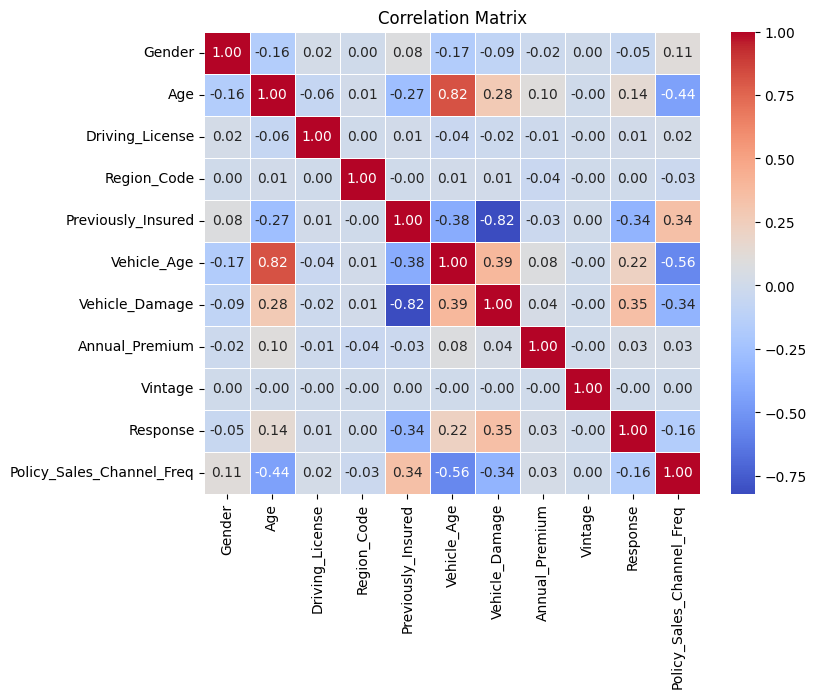

In [ ]:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation matrix using Spearman's method and round to 2 decimal places
correlation_matrix = df[numerical_columns].corr(method='spearman').round(2)

# Create the heatmap with rounded values
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set plot title
plt.title("Correlation Matrix")

# Display the plot
plt.show()

Dalla matrice di correlazione emerge che le variabili `Vehicle_Age`, `Vehicle_Damage` e `Previously_Insured` presentano una correlazione moderata con la variabile target `Response`.  

In particolare:  
- `Vehicle_Age` e `Vehicle_Damage` sono positivamente correlate a `Response`, indicando che un aumento di questi valori è associato a una maggiore probabilità di accettare l'offerta di cross-selling.  
- `Previously_Insured` è invece negativamente correlata a `Response`, il che significa che chi è già assicurato ha una minore propensione ad accettare l'offerta.  

Per approfondire queste relazioni, analizziamo più nel dettaglio l’associazione tra `Vehicle_Age`, `Vehicle_Damage`, `Previously_Insured` e la variabile target `Response`, verificando la loro significatività statistica.

Normalized Chi-Square Test Results
                     Chi-squared  Normalized Chi-squared  p-value
Vehicle_Age         18771.889904             9385.944952      0.0
Previously_Insured  44357.964722            44357.964722      0.0
Vehicle_Damage      47864.761801            47864.761801      0.0


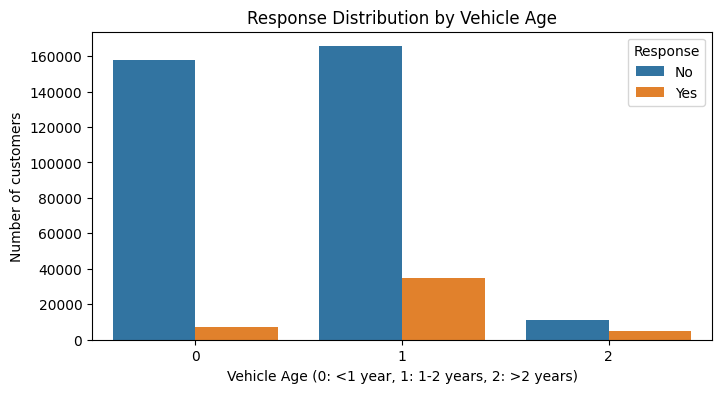

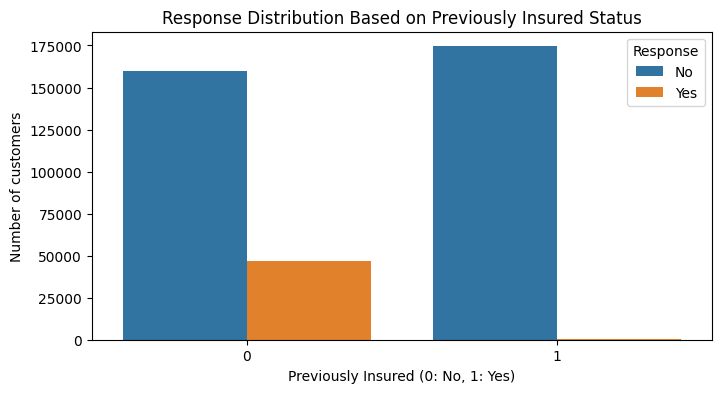

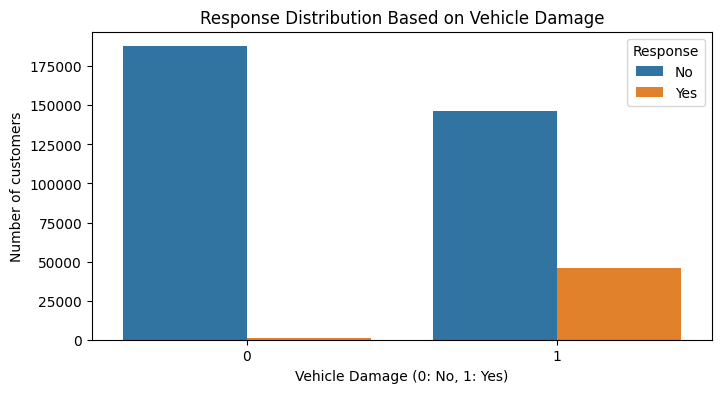

In [ ]:
# List of categorical variables to test
categorical_vars = ["Vehicle_Age", "Previously_Insured", "Vehicle_Damage"]

# Dictionary to store Chi-Square test results
chi2_results = {}

# Perform the Chi-Square test for each variable
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df["Response"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Compute the normalized Chi-Square
    chi2_norm = chi2 / dof if dof > 0 else 0  # Avoid division by zero

    chi2_results[var] = {
        "Chi-squared": chi2,
        "Normalized Chi-squared": chi2_norm,
        "p-value": p
    }

# Create a DataFrame with the results
chi2_df = pd.DataFrame.from_dict(chi2_results, orient="index")

# Print the Chi-Square test results
print("Normalized Chi-Square Test Results")
print(chi2_df)

# Bar plots to visualize the distribution of Response with respect to the variables
figsize = (8, 4)

# Plot for Vehicle_Age
plt.figure(figsize=figsize)
sns.countplot(x="Vehicle_Age", hue="Response", data=df)
plt.title("Response Distribution by Vehicle Age")
plt.xlabel("Vehicle Age (0: <1 year, 1: 1-2 years, 2: >2 years)")
plt.ylabel("Number of customers")
plt.legend(title="Response", labels=["No", "Yes"])
plt.show()

# Plot for Previously_Insured
plt.figure(figsize=figsize)
sns.countplot(x="Previously_Insured", hue="Response", data=df)
plt.title("Response Distribution Based on Previously Insured Status")
plt.xlabel("Previously Insured (0: No, 1: Yes)")
plt.ylabel("Number of customers")
plt.legend(title="Response", labels=["No", "Yes"])
plt.show()


# Plot for Previously_Insured
plt.figure(figsize=figsize)
sns.countplot(x="Vehicle_Damage", hue="Response", data=df)
plt.title("Response Distribution Based on Vehicle Damage")
plt.xlabel("Vehicle Damage (0: No, 1: Yes)")
plt.ylabel("Number of customers")
plt.legend(title="Response", labels=["No", "Yes"])
plt.show()

### **Analisi del Test Chi-Quadrato**  
Il test **Chi-Quadrato** ha prodotto un **p-value = 0.00**, significativamente inferiore a **0.05**. Questo ci consente di rifiutare l'ipotesi nulla e concludere che le variabili analizzate hanno un impatto significativo su `Response`.  

Inoltre, il valore elevato della statistica del **Chi-Quadrato normalizzato**, ben superiore a **1**, indica una **forte associazione** tra le categorie di `Vehicle_Age`, `Previously_Insured`, e `Response`.  


### **Analisi dei Grafici**  
L'analisi visiva dei dati conferma quanto emerso dal test statistico.  

#### **1. Vehicle_Age vs Response**  
Dal grafico che mette in relazione l'età del veicolo (`Vehicle_Age`) con la variabile target (`Response`), emergono i seguenti pattern:  
- I clienti con veicoli di 1-2 anni (`Vehicle_Age = 1`) accettano più frequentemente l'offerta di cross-selling rispetto agli altri gruppi.  
- I veicoli più nuovi (`Vehicle_Age = 0`) presentano un tasso di accettazione inferiore rispetto a quelli con 1-2 anni di anzianità.  

#### **2. Previously_Insured vs Response**  
Osservando il confronto tra `Previously_Insured` e `Response`, notiamo che:  
- I clienti non assicurati (`Previously_Insured = 0`) hanno una probabilità significativamente più alta di accettare l'offerta di cross-selling.  
- I clienti già assicurati (`Previously_Insured = 1`) mostrano invece un tasso di accettazione quasi nullo, suggerendo che chi ha già un'assicurazione è molto meno incline a cambiare fornitore o aggiungere una polizza.  

#### **3. Vehicle_Damage vs Response**  
Infine, l'analisi della variabile `Vehicle_Damage` evidenzia che:  
- I clienti che non hanno mai avuto incidenti o danni al veicolo tendono a rifiutare la proposta di cross-selling.  
- Al contrario, chi ha precedenti di danni o incidenti mostra una maggiore propensione ad accettare l’offerta.  

</br>

L'analisi con il test Chi-Quadrato e la visualizzazione dei dati confermano che le variabili `Vehicle_Age`, `Previously_Insured`, e `Vehicle_Damage` influenzano significativamente la probabilità che un cliente accetti l'offerta di cross-selling.  


In [ ]:
df["Response"].value_counts()

,count
Response,
0,334399
1,46710


In [ ]:
# Percentage of accepted cross-sell proposal
accepted_proposal= (df["Response"].sum() / len(df["Response"])) * 100

print(f"Percentage of accepted cross-sell proposal: {accepted_proposal:.2f}%")

Percentage of accepted cross-sell proposal: 12.26%


La percentuale di clienti che hanno accettato l'offerta di cross-selling è del **12,26%** del totale. Questo evidenzia un marcato sbilanciamento tra coloro che accettano e quelli che rifiutano la proposta.

## **Creazione e Addestramento del Modello su Dati Originali**
Costruiamo un modello di machine learning utilizzando il dataset originale, pur consapevoli dello sbilanciamento delle classi. Analizziamo quindi le performance per comprendere in che modo lo sbilanciamento influisce sulla capacità del modello di distinguere correttamente tra clienti propensi e non propensi al cross-selling.

In [ ]:
# Split the dataset while preserving the class distribution in train and test sets
X = df.drop("Response", axis=1)  # Extract feature variables by removing the 'Response' column
y = df["Response"]  # Define the target variable

# Perform train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [ ]:
# Standardization of features

# List of binary variables (0/1) to exclude
binary_vars = ['Previously_Insured', 'Vehicle_Damage', 'Driving_License', 'Response', 'Gender']

# Select only continuous variables for standardization
continuous_vars = [col for col in df.columns if col not in binary_vars]

# Initialize the StandardScaler
ss = StandardScaler()

# Standardize only the continuous variables in X_train
X_train[continuous_vars] = ss.fit_transform(X_train[continuous_vars])

# Apply the same transformation to X_test
X_test[continuous_vars] = ss.transform(X_test[continuous_vars])

In [ ]:
# Initialize the logistic regression model
lr = LogisticRegression()

# Train the model with the selected features
lr.fit(X_train, y_train)

## **Valutazione del Modello**

In [ ]:
# Obtain predicted probabilities
y_proba_train = lr.predict_proba(X_train)[:, 1]  # Probability of class 1
y_proba_test = lr.predict_proba(X_test)[:, 1]  # Probability of class 1

# Set a new threshold
threshold = 0.53
y_pred_train = np.where(y_proba_train >= threshold, 1, 0)
y_pred_test = np.where(y_proba_test >= threshold, 1, 0)

# New classification report with modified threshold
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Analizzando le performance del modello addestrato, emergono subito delle criticità nelle metriche. In particolare, i risultati sul set di test mostrano che **precision, recall e F1-score per la classe positiva sono pari a zero**, indicando che il modello **non riesce a identificare alcun caso positivo**. Questo significa che **fallisce completamente nel riconoscere i clienti potenzialmente interessati al cross-selling**, classificando quasi tutti come non interessati.  

Questa problematica è dovuta al forte **sbilanciamento della variabile target `Response`**, dove solo **il 12.26% delle osservazioni appartiene alla classe positiva**. In una situazione del genere, il modello può essere influenzato dalla classe dominante (negativa), imparando a **privilegiare la classe più rappresentata** per ottenere una maggiore accuratezza complessiva, a discapito della capacità di riconoscere i casi positivi.  

Per affrontare questo problema, applichiamo la tecnica dell'**Undersampling**, che consiste nel **ridurre il numero di esempi della classe maggioritaria** (clienti non interessati), selezionando casualmente un sottoinsieme di dati nel set di addestramento. Questo permette di riequilibrare la distribuzione delle classi e di migliorare la capacità del modello di riconoscere entrambi i gruppi in modo più bilanciato.

In [ ]:
# Count the number of samples for each class in the 'Response' variable
print(Counter(y))


Original distribution of Response:
Counter({0: 334399, 1: 46710})


In [ ]:
# Initialize undersampling
under = RandomUnderSampler(sampling_strategy=0.6, random_state=0)  # Ensuring consistency with the previous seed

# Apply undersampling
X, y= under.fit_resample(X, y)

# Verify the new class distribution
print("Distribution after Undersampling:")
print(Counter(y))

Distribution after Undersampling:
Counter({0: 77850, 1: 46710})


Il dataset è ora bilanciato: la classe maggioritaria (Response = 0) è stata ridotta del 60%. Questo ha portato a un rapporto più equilibrato tra le classi, favorendo una migliore generalizzazione del modello.  


## **Creazione e Addestramento del Modello su Dati Bilanciati**
Avendo ottenuto un dataset equilibrato, possiamo procedere con la costruzione del modello predittivo di machine learning, il quale stimerà la probabilità che un cliente risponda positivamente all'offerta di cross-sell. Questo consentirà di ottimizzare le campagne di marketing di AssurePredict, migliorando il ritorno sull’investimento.  

Poiché la variabile target Response è binaria, con due classi (1 = Sì, 0 = No), utilizzeremo un modello di **regressione logistica** per la classificazione binaria. Questo approccio è particolarmente adatto per stimare la probabilità che un cliente accetti o meno l’offerta di *cross-selling*, fornendo una base solida per prendere decisioni strategiche basate sui dati.

In [ ]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Standardization of features

# List of binary variables (0/1) to exclude
binary_vars = ['Previously_Insured', 'Vehicle_Damage', 'Driving_License', 'Response', 'Gender']

# Select only continuous variables for standardization
continuous_vars = [col for col in df.columns if col not in binary_vars]

# Initialize the StandardScaler
ss = StandardScaler()

# Standardize only the continuous variables in X_train
X_train[continuous_vars] = ss.fit_transform(X_train[continuous_vars])

# Apply the same transformation to X_test
X_test[continuous_vars] = ss.transform(X_test[continuous_vars])



In [ ]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Policy_Sales_Channel_Freq
265509,0,-1.233978,1,-1.052348,1,-1.246026,0,-0.316070,-1.352761,1.283080
200148,0,0.937087,1,0.117043,0,0.510453,1,0.479119,1.312820,0.091378
63943,1,1.276316,1,1.832149,1,0.510453,0,0.528075,0.452184,0.091378
363549,0,-0.555520,1,-1.442145,0,0.510453,1,-1.586072,-0.934396,-1.488269
55371,0,0.937087,1,1.832149,1,0.510453,0,0.249030,-1.436434,-0.032045


In [ ]:
# Initialize the logistic regression model
lr = LogisticRegression()

# Train the model with the selected features
lr.fit(X_train, y_train)


LogisticRegression()

## **Valutazione del Modello**

### **Classification Report (Precision, Recall, F1-score)**

In [ ]:
# Obtain predicted probabilities
y_proba_train = lr.predict_proba(X_train)[:, 1]  # Probability of class 1
y_proba_test = lr.predict_proba(X_test)[:, 1]  # Probability of class 1

# Set a new threshold
threshold = 0.53
y_pred_train = np.where(y_proba_train >= threshold, 1, 0)
y_pred_test = np.where(y_proba_test >= threshold, 1, 0)

# New classification report with modified threshold
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))




              precision    recall  f1-score   support

           0       0.85      0.73      0.79     54536
           1       0.63      0.79      0.70     32656

    accuracy                           0.75     87192
   macro avg       0.74      0.76      0.74     87192
weighted avg       0.77      0.75      0.75     87192

              precision    recall  f1-score   support

           0       0.85      0.73      0.79     23314
           1       0.64      0.79      0.71     14054

    accuracy                           0.75     37368
   macro avg       0.75      0.76      0.75     37368
weighted avg       0.77      0.75      0.76     37368



Scegliendo una soglia di decisione (threshold) pari al 53%, il modello acquisisce una buona capacità di individuare i clienti realmente propensi al cross-selling, mantenendo un equilibrio tra accuratezza e copertura.  

La **precisione** per la classe negativa è pari all’**85%**, indicando che la maggior parte dei clienti classificati come non interessati lo sono effettivamente. Per la classe positiva, la **precisione** raggiunge il **64%**, segnalando che il modello identifica con discreta affidabilità i clienti realmente propensi alla proposta.  

Il **recall**, che misura la capacità di catturare tutti i clienti effettivamente interessati, risulta abbastanza equilibrato tra le due classi. Il modello identifica correttamente il **73%** dei clienti che non accettano l’offerta (classe negativa) e il **79%** di quelli realmente propensi al cross-selling (classe positiva), suggerendo una buona copertura della classe minoritaria.  

Infine, l’**F1-score**, che rappresenta il compromesso tra precisione e recall, mostra valori soddisfacenti: **79%** per la classe negativa e **71%** per la classe positiva.

Questi risultati indicano che il modello è ben bilanciato e può supportare efficacemente le strategie di cross-selling, riducendo il rischio di falsi positivi e falsi negativi.

### **Cross Validation**
Applichiamo la tecnica di **cross-validation Stratified K-Fold** per verificare la robustezza del modello addestrato. Questa tecnica suddivide il dataset in più folds, permettendo di addestrare e testare il modello su diverse suddivisioni dei dati, migliorando così l'affidabilità della valutazione delle sue performance.  
A differenza della cross-validation tradizionale, utilizziamo la variante Stratified K-Fold, che garantisce che la proporzione delle classi nel dataset originale venga preservata in ogni fold. Questo aspetto è particolarmente importante nel nostro caso, poiché il dataset è sbilanciato e vogliamo evitare che alcuni folds contengano un numero eccessivamente ridotto di istanze della classe meno rappresentata, il che potrebbe compromettere l’addestramento del modello.

In [ ]:
# Define a pipeline with three steps:
pipeline = Pipeline([
    # Step 1: Apply Random Under-Sampling to balance the dataset
    ('oversampling', RandomUnderSampler(sampling_strategy=0.6, random_state=0)),

    # Step 2: Standardize features using StandardScaler
    ('scaler', StandardScaler()),

    # Step 3: Train a logistic regression classifier with increased iterations
    ('classifier', LogisticRegression(max_iter=1000, random_state=0))
])

# Define a stratified k-fold cross-validation with 5 splits to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Perform cross-validation using ROC AUC as the evaluation metric
results = cross_validate(
    pipeline, X, y, cv=cv, scoring="roc_auc",
    return_train_score=True, error_score='raise'
)

# Print the AUC score for each fold
print("AUC for each fold:", results['test_score'])

# Print the average AUC score across all folds
print("Mean AUC:", np.mean(results['test_score']))


AUC for each fold: [0.82734321 0.82899968 0.83107381 0.8285045  0.83272027]
Mean AUC: 0.8297282931745047


La media dell'AUC calcolata sui 5 fold della Stratified K-Fold cross-validation è pari a 0.82, un valore che indica un’ottima capacità del modello nel distinguere tra clienti propensi e non propensi ad accettare l’offerta di cross-selling. </br>
Un valore di AUC = 0.82 suggerisce che il modello ha buone performance generali, riuscendo a bilanciare correttamente il compromesso tra True Positive Rate (TPR) e False Positive Rate (FPR). </br>
Questo conferma la robustezza del modello, dimostrando che le sue prestazioni rimangono costanti su diversi sottoinsiemi del dataset, senza essere eccessivamente influenzato dai dati di training o test.

### **AUC-ROC Curve**

AUC: 0.8318170975567358


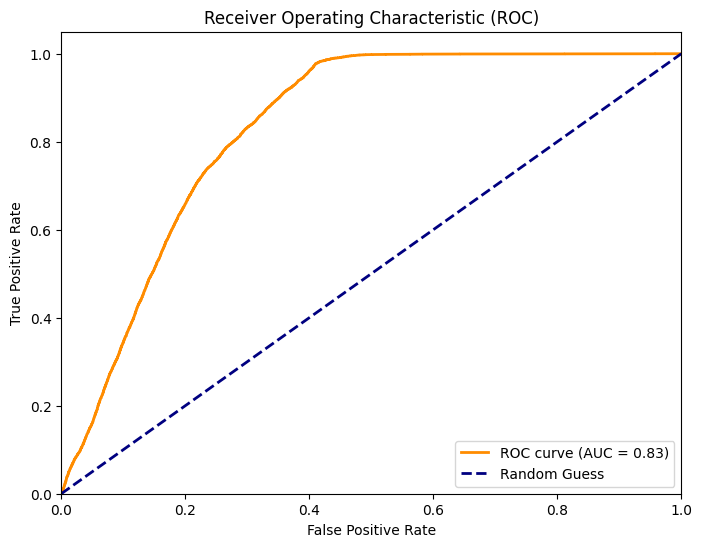

In [ ]:
# Compute FPR, TPR, and thresholds
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

# Compute AUC
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


1. **Interpretazione della Curva ROC** </br>
La curva ROC (Receiver Operating Characteristic) rappresenta il **compromesso tra il True Positive Rate (TPR, sensibilità) e il False Positive Rate (FPR)** a diverse soglie di decisione del modello. </br>
Osserviamo che:
  - La curva ROC è spostata verso l’alto a sinistra, il che indica buone performance del modello nel distinguere tra classi positive e negative.
  - La linea blu tratteggiata rappresenta un modello casuale (AUC = 0.5), mentre la curva arancione mostra il comportamento del nostro modello.

2. **Valutazione dell'AUC (Area Under the Curve)**
  - Il valore **AUC = 0.83** indica che il modello ha **un’ottima capacità di discriminare tra clienti propensi e non propensi al cross-sell**.
  - Un AUC vicino a **1.0** indica un modello perfetto, mentre **0.5** rappresenterebbe un modello casuale.

</br>

Il modello in generale ha **buone performance**, con un'elevata capacità di identificare correttamente i clienti interessati al cross-sell minimizzando i falsi positivi.


### **Log Loss**

In [ ]:
from sklearn.metrics import log_loss
log_loss_train=log_loss(y_train, y_proba_train)
log_loss_test=log_loss(y_test, y_proba_test)
print(f"Log Loss (Train): {log_loss_train:.3f}")
print(f"Log Loss (Test): {log_loss_test:.3f}")

Log Loss (Train): 0.441
Log Loss (Test): 0.440


Misurando la Log Loss, che rappresenta l’incertezza delle previsioni del modello, otteniamo valori molto simili tra il set di training (0.441) e il set di test (0.440).  
Questa stabilità indica che il modello generalizza bene e non soffre di overfitting, poiché l’errore di classificazione rimane costante su dati mai visti prima.  
Inoltre, il valore osservato è discreto,  indicando che il modello assegna probabilità coerenti e produce previsioni abbastanza affidabili.


### **Confusion Matrix**

Costruiamo la matrice di confusione per visualizzare chiaramente la distribuzione delle previsioni corrette e errate, suddivise per classe.


In [ ]:
# Create a function to plot the confusion matrix, adding Precision and Recall.

def plot_confusion_matrix(y_true, y_pred, show_precision_recall=False, labels=["Negative", "Positive"]):

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)  # [tn, fp, fn, tp]

    # Create a DataFrame for the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels,
                         columns=["Predicted " + labels[0], "Predicted " + labels[1]])

    # Display the confusion matrix using a heatmap
    sns.heatmap(df_cm, annot=True, fmt="g")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")

    # Show precision and recall if requested
    if show_precision_recall:
        precision = cm[1][1] / (cm[1][1] + cm[0][1])  # tp / (tp + fp)
        recall = cm[1][1] / (cm[1][1] + cm[1][0])    # tp / (tp + fn)
        plt.text(0, -0.1, f"Precision: {precision:.3f}", fontsize=10, ha="center")
        plt.text(1, -0.1, f"Recall: {recall:.3f}", fontsize=10, ha="center")

    plt.show()


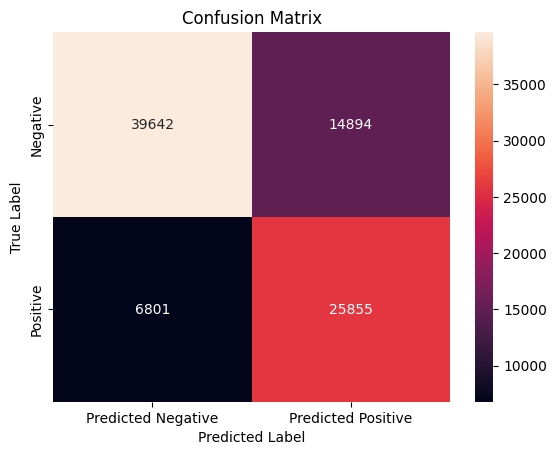

In [ ]:
plot_confusion_matrix(y_train, y_pred_train)

Dalla matrice di confusione, osserviamo che 6801 istanze sono state erroneamente classificate come negative, mentre in realtà appartenevano alla classe positiva (falsi negativi). Allo stesso tempo, 14894 istanze sono state previste come positive, ma in realtà erano negative (falsi positivi).  

Questo indica che il modello commette più errori nel classificare esempi negativi come positivi piuttosto che il contrario, portando a una sovrastima della classe positiva. Di conseguenza, il numero di falsi positivi è relativamente alto rispetto ai falsi negativi.  

Un’alta quantità di falsi positivi implica che il modello identifica erroneamente alcuni clienti come propensi al cross-sell, quando in realtà non lo sono. Questo potrebbe tradursi in costi aggiuntivi per l’azienda, ad esempio nel caso di campagne di marketing dirette a clienti poco interessati, riducendo l’efficacia delle strategie promozionali.  

Tuttavia, il fatto che il numero di falsi negativi sia inferiore suggerisce che il modello riesce comunque a intercettare buona parte dei clienti realmente propensi alla propost. Questo è un aspetto positivo, poiché riduce il rischio di perdere opportunità di vendita, garantendo che la maggior parte dei clienti interessati venga effettivamente identificata.